In [44]:
from torchvision import transforms
import numpy as np
import torch
import torch.autograd as autograd
from torch.autograd import Variable, Function
from torch.nn.parameter import Parameter
import torch.nn as nn
import pylab as pl
import time
import math
import pickle
from IPython import display
import torch.nn.functional as F
from copy import deepcopy
import cifarResnet
import matplotlib.pyplot as plt
from scipy.misc import bytescale

torch.cuda.set_device(3) # Set gpu number here

In [45]:
# Load the data

traindata = []
labels = []
for i in range(1,6):
    with open('/data/cifar10/data_batch_'+str(i), 'rb') as fo:
        d = pickle.load(fo, encoding='bytes')
        traindata.append(d[b'data'].reshape(10000,3,32,32))
        labels.append(d[b'labels'])
traindata = np.concatenate(traindata,axis=0)
labels = np.concatenate(labels,axis=0)
with open('/data/cifar10/test_batch', 'rb') as fo:
    d = pickle.load(fo, encoding='bytes')
    testdata = d[b'data'].reshape(10000,3,32,32)
    testlabels = np.array(d[b'labels'])
'''
plt.imshow(bytescale(testdata[1]).astype(np.float64).transpose((1,2,0)),interpolation='nearest')
plt.show()
print(testlabels[1])
''' 
traindata = torch.Tensor(traindata.astype(np.float64))
testdata = torch.Tensor(testdata.astype(np.float64))
labels = torch.Tensor(labels.astype(np.float64)).long()
testlabels = torch.Tensor(testlabels.astype(np.float64)).long()
standardize = transforms.Normalize(mean=[125.3, 123, 113.9],std=[63, 62.1, 66.7])
traindata = torch.cat([standardize(traindata[i]).view(1,3,32,32) for i in range(len(traindata))],dim=0).float()
testdata = torch.cat([standardize(testdata[i]).view(1,3,32,32) for i in range(len(testdata))],dim=0).float()

In [46]:
# Define our helper functions

def alter(t):
    # flip and crop
    if np.random.random(1) > .5:
        inv_idx = torch.arange(t.size(2)-1,-1,-1).long()
        result = t[:,:,inv_idx]
    else:
        result = t
    result = F.pad(result.view(1,3,32,32),(4,4,4,4)).data
    x = np.random.randint(0,high=9)
    y = np.random.randint(0,high=9)
    return result[0,:,x:x+32,y:y+32].contiguous()

def batchmaker(theset, thelabels, shot=100, alterful=False):
    batch = np.random.choice(len(theset),shot,replace=False)
    data = (torch.cat([alter(theset[i]).view(1,3,32,32) for i in batch],dim=0).float()
            if alterful else
            torch.cat([theset[i].view(1,3,32,32) for i in batch],dim=0).float())
    labels = torch.LongTensor(np.array([thelabels[i] for i in batch]))
    
    return(Variable(data).cuda(),
           Variable(labels).cuda()
          )

criterion = nn.CrossEntropyLoss().cuda()

def evaluate(model, criterion, testing_data, testing_labels, shot=1000):
    support, targs = batchmaker(testing_data, testing_labels, shot=shot)
    c = 200
    assert shot%c==0
    batches = int(shot//c)
    support = support.view(batches, c, 3, 32, 32)
    targs = targs.view(batches, c)
    acc = 0
    loss = 0
    with torch.no_grad():
        for i in range(batches):
            preds = model(support[i,:,:,:,:])
            loss += criterion(preds, targs[i,:]).data[0]
            _,bins = torch.max(preds, 1)
            acc += torch.sum(torch.eq(bins,targs[i,:])).data[0]
    acc = float(acc)/shot
    loss = float(loss)/batches
    return loss, acc

In [47]:
# Build a test model, count parameters

model = cifarResnet.ResNet(9,16)
nweights = sum([i.numel() for i in list(model.parameters())])
print(nweights," parameters in neural net.")

855770  parameters in neural net.


Approximately 0.00 hours to completion


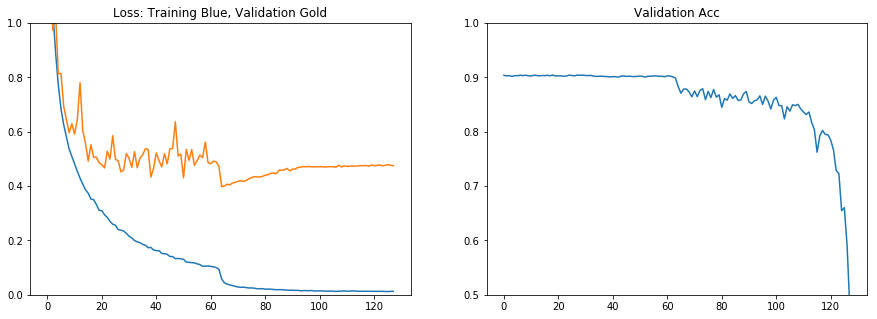

Train loss is: 0.012785316444933414
Validation accuracy is: 0.9037
Validation loss is: 0.47484851837158204

[]
Average score is 0.9037


'\nif len(ensemble) > 1:\n    print("95% confidence interval is", np.sqrt(np.var(allscores)/len(ensemble))*1.96)\n'

In [48]:
# Train!

%matplotlib inline

vbity = 500
epoch = 16000
limit = 64000
ensemble = list(range(1)) # Set the number of models that you want to train here
allscores = []
alltrainloss = []
alltestloss = []
start = time.time()
for b in ensemble:
    model = cifarResnet.ResNet(9,16).cuda()
    optimizer = torch.optim.SGD(model.parameters(),lr=.1,weight_decay=.0001,momentum=.9)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda x: min(1/(10**(x)),.1))
    losstracker = []
    evalacctracker = []
    evallosstracker = []
    runningloss = 0
    for it in range(limit):
        if it%50==0:
            print(it)

        # Build batch
        support, targs = batchmaker(traindata, labels, alterful=True, shot=128)

        # Predict
        model.zero_grad()
        preds = model(support)

        # Calculate Loss
        loss = criterion(preds, targs)
        runningloss += loss.item()

        # Backprop
        if it%epoch == 0:
            scheduler.step()
        loss.backward()
    #     nn.utils.clip_grad_norm(model.parameters(), 1)
        optimizer.step()

        # Report
        if it%vbity == vbity-1:
            display.clear_output(wait=True)
            print("Approximately %.2f hours to completion"%(
                (time.time()-start)/(it+1+b*limit)*((len(ensemble)-b)*limit-it)/3600))

            losstracker.append(runningloss/vbity)
            model = model.eval()
            evalloss, evalacc = evaluate(model, criterion, testdata, testlabels, shot=10000)
            model = model.train()
            evallosstracker.append(evalloss)
            evalacctracker.append(evalacc)

            pl.figure(1,figsize=(15,5))
            pl.subplot(1,2,1)
            pl.plot(losstracker)
            pl.plot(evallosstracker)
            pl.ylim((0,1))
    #         pl.xlim((0,limit*epoch))
            pl.title("Loss: Training Blue, Validation Gold")
            pl.subplot(1,2,2)
            pl.plot(evalacctracker[::-1])
            pl.ylim((0.5,1))
    #         pl.xlim((0,limit*epoch))
            pl.title("Validation Acc")
            pl.show()

            print("Train loss is: "+str(runningloss/vbity)+
                  "\nValidation accuracy is: "+str(evalacc)+
                  "\nValidation loss is: "+str(evalloss)+"\n")
            runningloss = 0
            print(allscores)
    model.eval()
    _,score = evaluate(model, criterion, testdata, testlabels, shot=10000)
    allscores.append(score)
    alltrainloss.append(losstracker)
    alltestloss.append(evallosstracker)
    
print("Average score is", np.mean(allscores))
'''
if len(ensemble) > 1:
    print("95% confidence interval is", np.sqrt(np.var(allscores)/len(ensemble))*1.96)
'''

In [64]:
#print(testdata[5])
preds=model(Variable(testdata[1]).cuda().view(-1,3,32,32))
_,bins = torch.max(preds, 1)
print(bins)
print(testlabels[1])

tensor([ 8], device='cuda:3')
tensor(8)


In [56]:

# Saving a Model
torch.save(model.state_dict(), '/data/xay2/scripts/pretrained_resnet/cifar10.pth')


In [57]:
for param in model.parameters():
  print(param.data)

tensor([[[[ 0.3169,  0.2690, -0.1390],
          [ 0.4778,  0.3353, -0.2707],
          [ 0.0528, -0.2346, -0.3384]],

         [[ 0.2122,  0.1424,  0.0414],
          [ 0.2865, -0.0557, -0.2638],
          [-0.1809, -0.6106, -0.3735]],

         [[ 0.0483,  0.1171,  0.0018],
          [ 0.2765,  0.2401,  0.0169],
          [-0.1649, -0.2265, -0.0597]]],


        [[[-0.0133, -0.1575, -0.0648],
          [ 0.1096, -0.2813,  0.1540],
          [-0.1660, -0.1289,  0.2142]],

         [[ 0.1021, -0.0464,  0.0656],
          [ 0.0089, -0.4014, -0.0074],
          [-0.2204, -0.2375,  0.0771]],

         [[-0.0454,  0.1009,  0.0368],
          [ 0.0318, -0.1053, -0.0576],
          [ 0.2570, -0.1818, -0.0372]]],


        [[[ 0.5952,  0.0814,  0.0599],
          [ 0.3479, -0.4066, -0.3755],
          [-0.0742, -0.5802, -0.6661]],

         [[ 0.0099, -0.3862, -0.0676],
          [ 0.2658, -0.1914,  0.0141],
          [ 0.1042, -0.0362,  0.1646]],

         [[-0.4604, -0.5912, -0.1700],
     

tensor([[[[-9.1301e-02, -9.5209e-02, -1.8350e-02],
          [-2.4411e-02,  5.9570e-02,  1.9802e-02],
          [-8.7712e-02, -1.1844e-01, -1.0314e-01]],

         [[ 1.0848e-01,  1.1315e-01, -2.9123e-02],
          [ 1.0497e-01, -3.2553e-02,  9.7746e-02],
          [-1.1846e-01, -7.4527e-02, -8.0922e-02]],

         [[ 4.3683e-02, -1.6280e-02, -4.2222e-02],
          [ 2.4146e-02,  6.5398e-04,  3.5757e-02],
          [ 9.6979e-02, -3.3131e-03,  2.3716e-02]],

         ...,

         [[-4.1903e-02,  7.7475e-02,  2.8217e-02],
          [-7.6782e-02,  1.1734e-01,  7.2016e-02],
          [-1.5873e-01,  2.8634e-02,  1.0651e-01]],

         [[-1.9808e-01, -7.8953e-02,  2.9408e-02],
          [ 1.5117e-02,  1.1325e-01, -2.5144e-02],
          [-5.1397e-02,  2.1023e-03, -5.7172e-02]],

         [[ 7.2619e-02,  7.6335e-02, -1.3189e-01],
          [ 1.2087e-02, -7.7679e-02, -7.9923e-02],
          [-3.8891e-02, -1.8317e-01, -1.0469e-01]]],


        [[[-4.2920e-04, -9.5027e-02, -2.3407e-02],
  

tensor([[[[ 3.2293e-03,  1.3481e-02, -1.5848e-02],
          [ 1.3516e-02,  3.5264e-02, -3.5519e-02],
          [-2.5274e-02, -5.4951e-02, -1.2517e-02]],

         [[-2.6602e-02, -5.7631e-02, -6.9105e-02],
          [-9.2315e-03, -9.4571e-03, -1.4127e-02],
          [-2.9418e-02,  4.5355e-02,  5.8270e-02]],

         [[ 3.7749e-02,  2.7241e-03, -7.2412e-02],
          [-1.1324e-01,  1.9847e-02, -1.8134e-02],
          [ 5.7560e-04, -3.3866e-03, -4.2619e-02]],

         ...,

         [[-2.1244e-01, -1.1382e-01, -8.9906e-02],
          [-1.6350e-01, -1.0281e-01, -1.0933e-01],
          [-3.8621e-02, -9.8961e-02, -1.0882e-01]],

         [[-3.9733e-02,  9.7135e-02,  9.2554e-02],
          [-5.6170e-02, -4.9437e-02, -3.4518e-03],
          [ 4.6265e-03,  1.0063e-02, -2.4522e-02]],

         [[ 5.1786e-02,  3.8330e-02, -5.9088e-02],
          [ 8.1744e-03,  7.0664e-02,  2.9157e-02],
          [ 3.4032e-02,  6.1917e-02,  1.9217e-02]]],


        [[[ 2.7720e-02,  9.6723e-03,  3.7206e-02],
  

tensor([[[[ 1.0180e-02,  5.7862e-02, -6.3931e-03],
          [-2.8888e-02,  4.3615e-02,  5.6075e-02],
          [-5.4935e-02,  6.0005e-02, -4.8072e-02]],

         [[ 2.6590e-02, -1.0101e-02,  9.6260e-03],
          [ 4.0076e-02, -5.1609e-03,  3.2704e-02],
          [ 6.7925e-02,  2.3425e-02,  7.7636e-02]],

         [[-4.0020e-02,  3.4141e-02,  2.5440e-03],
          [-1.8948e-02, -1.4425e-02,  1.3420e-02],
          [ 4.8800e-03,  7.4081e-02,  1.3356e-02]],

         ...,

         [[ 2.0810e-02,  7.4927e-02,  3.7349e-02],
          [ 1.7380e-02,  1.6470e-01,  4.9648e-02],
          [ 1.8011e-02, -1.5854e-02, -7.9056e-02]],

         [[ 7.5777e-03, -8.7957e-02, -2.6030e-02],
          [-4.3260e-02, -3.4382e-02, -4.3646e-02],
          [ 4.4108e-03,  4.3239e-02,  9.6906e-03]],

         [[-3.2793e-02, -2.8250e-02,  6.5681e-03],
          [ 8.5382e-03, -4.0296e-02,  2.8166e-02],
          [-1.2961e-02,  7.7262e-02, -3.1318e-02]]],


        [[[-1.0723e-02,  4.4346e-02,  4.3557e-02],
  